# Imports + Path Specification

In [2]:
import sys
import os
import torch
from torch import optim
from time import time
import random

In [3]:
tile2vec_dir = '/home/agupta21/gcloud/231n_gitproject' # Uncomment for anshul
# tile2vec_dir = '/home/shailimonchik/project' # Uncomment for Shai
sys.path.append('../')
sys.path.append(tile2vec_dir)

In [4]:
from src.datasets import TileTripletsDataset, GetBands, RandomFlipAndRotate, ClipAndScale, ToFloatTensor, triplet_dataloader
from src.tilenet import make_tilenet

In [5]:
from src.training import prep_triplets, train_triplet_epoch

In [6]:
import numpy as np
from torch.autograd import Variable
import sys
from src.resnet import ResNet18

In [7]:
#Random Forest Classification

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Dataloader + TileNet Setup

In [8]:
# Environment stuff
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda = torch.cuda.is_available()
print(cuda)

True


In [9]:
# Defining Parameters
img_type = 'naip'
tile_dir = '/home/agupta21/gcloud/231n_gitproject/data/triplets/'
bands = 4
augment = False
batch_size = 50
shuffle = True
num_workers = 6
n_triplets = 100000

In [9]:
dataloader = triplet_dataloader(img_type, tile_dir, bands=bands, augment=augment,
                                batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, 
                                n_triplets=n_triplets, pairs_only=False) #HYPERPARAMETER TURNED
print('Dataloader set up complete.')

Dataloader set up complete.


In [10]:
#generate list
random.seed(21)
randList = []
while len(randList)!= 10000:
    randIndex = random.randint(0,99999)
    if randIndex not in randList:
        randList.append(randIndex)
print(len(randList))

randSet = set(randList)
print(len(randSet))
print(list(randSet)[0]) #65339

10000
10000
65539


In [11]:
# tripletsToLabels = {}
# for idx in range(65538,100000):
#     if idx in randSet:
#         #do shit
#         part1 = "../data/triplets/" + str(idx)
#         anchor = np.load(part1 + "anchor.npy")
#         neighbor = np.load(part1 + "neighbor.npy")
#         distant = np.load(part1 + "distant.npy")
#         counts_anchor = np.bincount(anchor[:,:,4].reshape(2500,))
#         anchor_label = np.argmax(counts_anchor)
#         counts_nei = np.bincount(neighbor[:,:,4].reshape(2500,))
#         neighbor_label = np.argmax(counts_nei)
#         counts_distant = np.bincount(distant[:,:,4].reshape(2500,))
#         distant_label = np.argmax(counts_distant)
#         tripletsToLabels[idx] = (anchor_label, neighbor_label, distant_label)
#     if idx == 65539:
#         print(anchor_label,neighbor_label,distant_label)
        
#         print('Key is {}, Labels are {}'.format(idx, tripletsToLabels[idx]))
#     if idx % 10000 == 0:
#         print('idx is {}'.format(idx))
# print(len(tripletsToLabels))

In [12]:
# #Get set of all values:
# allVals = set()
# for idx in range(100000):
#     if idx % 1000 == 0:
#         print(idx)
#     part1 = "../data/triplets/" + str(idx)
#     anchor = np.load(part1 + "anchor.npy")
#     neighbor = np.load(part1 + "neighbor.npy")
#     distant = np.load(part1 + "distant.npy")
#     counts_anchor = np.bincount(anchor[:,:,4].reshape(2500,))
#     anchor_label = np.argmax(counts_anchor)
#     counts_nei = np.bincount(neighbor[:,:,4].reshape(2500,))
#     neighbor_label = np.argmax(counts_nei)
#     counts_distant = np.bincount(distant[:,:,4].reshape(2500,))
#     distant_label = np.argmax(counts_distant)
#     allVals.add(anchor_label)
#     allVals.add(neighbor_label)
#     allVals.add(distant_label)
# print(len(allVals))
# print(allVals)

In [11]:
#Transform the dict: 
allVals = {1, 2, 131, 4, 3, 12, 141, 142, 21, 22, 23, 24, 152, 27, 28, 33, 36, 37, 41, 42, 43, 44, 176, 49, 48, 53, 54, 59, 61, 190, 66, 67, 195, 69, 71, 72, 74, 75, 76, 205, 204, 206, 208, 77, 209, 211, 212, 213, 216, 217, 218, 220, 225, 226, 227, 236, 237, 111, 242, 121, 122, 123, 124}
print(set(allVals))
le = LabelEncoder()
transformedLabels = le.fit_transform(list(allVals))
print(transformedLabels)
print(set(transformedLabels))


{1, 2, 3, 131, 4, 12, 141, 142, 21, 22, 23, 24, 152, 27, 28, 33, 36, 37, 41, 42, 43, 44, 176, 49, 48, 53, 54, 59, 61, 190, 66, 67, 195, 69, 71, 72, 74, 75, 76, 205, 204, 206, 208, 77, 209, 211, 212, 213, 216, 217, 218, 220, 225, 226, 227, 236, 237, 111, 242, 121, 122, 123, 124}
[ 0  1  2 38  3  4 39 40  5  6  7  8 41  9 10 11 12 13 14 15 16 17 42 19
 18 20 21 22 23 43 24 25 44 26 27 28 29 30 31 46 45 47 48 32 49 50 51 52
 53 54 55 56 57 58 59 60 61 33 62 34 35 36 37]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62}


In [14]:
# tile_dir = '../data/tiles'
# n_tiles = 1000
# y = np.load(os.path.join(tile_dir, 'y.npy'))
# print(y.shape)
# print(set(y))


In [15]:
# for i in set(y):
#     val = int(i)
#     if val not in allVals:
#         print("Crushing")

In [16]:
# #DO NOT RUN THIS ANYMORE
# f = open('tripletsToLabels2', 'w')
# f.write(str(tripletsToLabels))
# f.close()

In [12]:
tempDict = eval(open('tripletsToLabels', 'r').read())
print(len(tempDict))

print(tempDict[65539])

10000
(123, 69, 69)


In [13]:
#DONT RUN THIS AGAIN!!!!! (actually you can )
for key, value in tempDict.items():
    value2 = le.transform(value)
    tempDict[key] = value2
maxVal = 0
for key, value in tempDict.items():
    maxP = max(value)
    if maxP > maxVal:
        maxVal = maxP
print(maxVal)

61


In [14]:
in_channels = bands
z_dim = 512

In [20]:
TileNet = make_tilenet(in_channels=in_channels, z_dim=z_dim, strat2=True, dictionary_labels=tempDict, idx_include=randSet)
TileNet.train()
if cuda: TileNet.cuda()
print('TileNet set up complete.')

TileNet set up complete.


In [21]:
#Hyperparameter 
lr = 1e-3
optimizer = optim.Adam(TileNet.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Model + Writing Each Epoch to File

In [15]:
epochs = 10
margin = 10
l2 = 0.01
print_every = 10000
save_models = True

In [16]:
model_dir = '/home/agupta21/gcloud/231n_gitproject/models/'
if not os.path.exists(model_dir): os.makedirs(model_dir)

In [ ]:
t0 = time()
#with open(results_fn, 'w') as file:

total_list = []
small_list = []
print('Begin training.................')
for epoch in range(0, epochs):
    (avg_loss, avg_small,avg_l_n, avg_l_d, avg_l_nd) = train_triplet_epoch(
        TileNet, cuda, dataloader, optimizer, epoch+1, margin=margin, l2=l2,
        print_every=print_every, t0=t0)
    total_list.append((epoch+1,avg_loss))
    small_list.append((epoch+1,avg_small))
    append_name = "strat2.1_ep" + str(epoch+1) + ".ckpt"
    if save_models:
        model_fn = os.path.join(model_dir,append_name)
        torch.save(TileNet.state_dict(),model_fn)

Begin training.................
Epoch 1: [10000/100000 (10%)], Avg loss: 9.4882
Epoch 1: [20000/100000 (20%)], Avg loss: 10.5721
Epoch 1: [30000/100000 (30%)], Avg loss: 11.4421
Epoch 1: [40000/100000 (40%)], Avg loss: 9.4240
Epoch 1: [50000/100000 (50%)], Avg loss: 8.5002
Epoch 1: [60000/100000 (60%)], Avg loss: 9.1728
Epoch 1: [70000/100000 (70%)], Avg loss: 9.1027
Epoch 1: [80000/100000 (80%)], Avg loss: 10.2380
Epoch 1: [90000/100000 (90%)], Avg loss: 10.2716
Epoch 1: [100000/100000 (100%)], Avg loss: 8.6404
Finished epoch 1: 2361.557s
  Average loss: 9.6852
  Average l_n: 3.5539
  Average l_d: -13.5885
  Average l_nd: -10.0346

Epoch 2: [10000/100000 (10%)], Avg loss: 9.2372
Epoch 2: [20000/100000 (20%)], Avg loss: 9.7730
Epoch 2: [30000/100000 (30%)], Avg loss: 10.7317
Epoch 2: [40000/100000 (40%)], Avg loss: 8.9207
Epoch 2: [50000/100000 (50%)], Avg loss: 7.9594
Epoch 2: [60000/100000 (60%)], Avg loss: 8.6866
Epoch 2: [80000/100000 (80%)], Avg loss: 9.6605
Epoch 2: [90000/100000

In [29]:
print(total_list)
print(small_list)


[(1, 9.685210390329361), (2, 9.185549191832543), (3, 9.12851038134098), (4, 9.00385660457611), (5, 8.722187658905982), (6, 8.538859692811966), (7, 8.513230026483535), (8, 8.26561591911316), (9, 8.036771008729934)]
[(1, 5.734011413691712), (2, 5.390026954658409), (3, 5.466318980083601), (4, 5.42163113568589), (5, 5.221251976791647), (6, 5.088228962837617), (7, 5.120239342305789), (8, 4.914984510307085), (9, 4.747061328997647)]


# Pre Process Y Values

In [17]:
#note to self: need to embed tiles first and then figure out loop for reading in the saved model and plotting
#the classification accuracies per epoch
tile_dir = '../data/tiles'
n_tiles = 1000
y = np.load(os.path.join(tile_dir, 'y.npy'))
print(y.shape)

(1000,)


In [18]:
# Check CDL classes
print(set(y))

{1.0, 2.0, 21.0, 24.0, 152.0, 28.0, 36.0, 176.0, 49.0, 54.0, 61.0, 69.0, 71.0, 72.0, 75.0, 76.0, 205.0, 204.0, 208.0, 212.0, 217.0, 225.0, 236.0, 111.0, 121.0, 122.0, 123.0, 124.0}


In [19]:
y = le.fit_transform(y)
print(set(y))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}


# Load in Epochs' Weights + Run each on tile embeddings + Random Forest 

In [20]:
#set up model
in_channels = 4
z_dim = 512
cuda = torch.cuda.is_available()

In [21]:
def getTileEmbeddings(tilenet):
    X = np.zeros((n_tiles, z_dim))
    for idx in range(n_tiles):
        tile = np.load(os.path.join(tile_dir, '{}tile.npy'.format(idx+1)))
        # Get first 4 NAIP channels (5th is CDL mask)
        tile = tile[:,:,:4]
        # Rearrange to PyTorch order
        tile = np.moveaxis(tile, -1, 0)
        tile = np.expand_dims(tile, axis=0)
        # Scale to [0, 1]
        tile = tile / 255
        # Embed tile
        tile = torch.from_numpy(tile).float()
        tile = Variable(tile)
        if cuda: tile = tile.cuda()
        z = tilenet.encode(tile)
        if cuda: z = z.cpu()
        z = z.data.numpy() #1 by 512
        X[idx,:] = z
    return X

In [22]:
epochsToAccuracy = []
epochsToSTD = []
for i in range(0,9): #iterator
    curEpoch = i + 1
    # Setting up model
    tilenet = ResNet18()
    if cuda: tilenet.cuda()
    model_fn = "../models/strat2.1_ep"+str(curEpoch)+".ckpt" #open file
    #checkpoint = torch.load(model_fn)
    tilenet.load_state_dict(torch.load(model_fn), strict=False)
    #tilenet.load_state_dict(checkpoint)
    tilenet.eval()
    
    X = getTileEmbeddings(tilenet) #function above
    
    #train random forest classifier
    n_trials = 100
    accs = np.zeros((n_trials,))
    for i in range(n_trials):
        # Splitting data and training RF classifer
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
        rf = RandomForestClassifier(n_estimators = 100)
        rf.fit(X_tr, y_tr) #X-tr is 512 by 1
        accs[i] = rf.score(X_te, y_te)
    print("Results for Epoch Number: ", str(curEpoch))
    print('Mean accuracy: {:0.4f}'.format(accs.mean()))
    print('Standard deviation: {:0.4f}'.format(accs.std()))
    epochsToAccuracy.append((curEpoch,accs.mean()))
    epochsToSTD.append((curEpoch,accs.std()))
print(epochsToAccuracy)
print(epochsToSTD)
    #save value
    
    
    
    

Results for Epoch Number:  1
Mean accuracy: 0.6696
Standard deviation: 0.0295
Results for Epoch Number:  2
Mean accuracy: 0.6790
Standard deviation: 0.0312
Results for Epoch Number:  3
Mean accuracy: 0.6776
Standard deviation: 0.0317
Results for Epoch Number:  4
Mean accuracy: 0.7079
Standard deviation: 0.0314
Results for Epoch Number:  5
Mean accuracy: 0.7007
Standard deviation: 0.0292
Results for Epoch Number:  6
Mean accuracy: 0.7059
Standard deviation: 0.0288
Results for Epoch Number:  7
Mean accuracy: 0.7163
Standard deviation: 0.0304
Results for Epoch Number:  8
Mean accuracy: 0.7112
Standard deviation: 0.0348
Results for Epoch Number:  9
Mean accuracy: 0.7031
Standard deviation: 0.0308
[(1, 0.6696), (2, 0.6789999999999998), (3, 0.6776499999999999), (4, 0.7079000000000001), (5, 0.7007499999999999), (6, 0.7058999999999997), (7, 0.71625), (8, 0.7112), (9, 0.7030999999999998)]
[(1, 0.02945063666544408), (2, 0.031216982557575917), (3, 0.03169743680489006), (4, 0.03141003024513029), (

In [23]:
print(epochsToSTD)

[(1, 0.02945063666544408), (2, 0.031216982557575917), (3, 0.03169743680489006), (4, 0.03141003024513029), (5, 0.029235038908816235), (6, 0.028769602013236112), (7, 0.03044154233937564), (8, 0.034829010896090626), (9, 0.03082839600108963)]


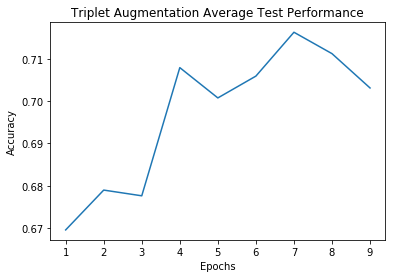

0.7030999999999998 was the final Accuracy


In [26]:
import matplotlib.pyplot as plt
plt.plot(*zip(*epochsToAccuracy))
plt.title('Triplet Augmentation Average Test Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(epochsToAccuracy[8][1], "was the final Accuracy")

The min loss was 8.036771008729934


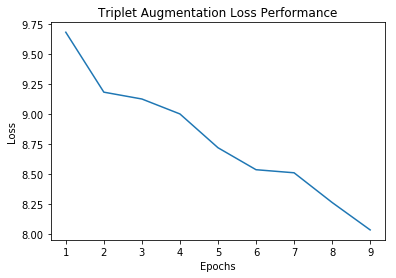

In [29]:
total_list = [(1, 9.685210390329361), (2, 9.185549191832543), (3, 9.12851038134098), (4, 9.00385660457611), (5, 8.722187658905982), (6, 8.538859692811966), (7, 8.513230026483535), (8, 8.26561591911316), (9, 8.036771008729934)]
#copy pasted the total list from the run
plt.plot(*zip(*total_list))
plt.title('Triplet Augmentation Loss Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
print("The min loss was",str(total_list[8][1]))
plt.show()

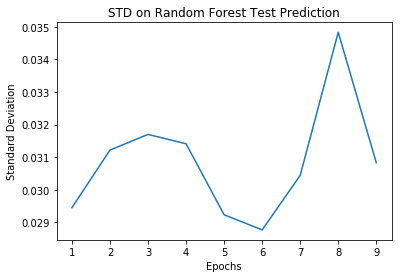

In [28]:
plt.plot(*zip(*epochsToSTD))
plt.title('STD on Random Forest Test Prediction')
plt.xlabel('Epochs')
plt.ylabel('Standard Deviation')
plt.show()

In [30]:
#iterator
i = 8
curEpoch = i + 1
# Setting up model
tilenet = ResNet18()
if cuda: tilenet.cuda()
model_fn = "../models/strat2.1_ep"+str(curEpoch)+".ckpt" #open file
#checkpoint = torch.load(model_fn)
tilenet.load_state_dict(torch.load(model_fn), strict=False)
#tilenet.load_state_dict(checkpoint)
tilenet.eval()

X = getTileEmbeddings(tilenet) #function above

#train random forest classifier
n_trials = 100
accs = np.zeros((n_trials,))
#for i in range(n_trials):
    # Splitting data and training RF classifer
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_tr, y_tr) #X-tr is 512 by 1
rf_predictions = rf.predict(X_te)
print(rf_predictions.shape)
rf_probs = rf.predict_proba(X_te)[:, 1]
print(rf_probs.shape)

# from sklearn.metrics import roc_auc_score
# roc_value = roc_auc_score(y_te, rf_probs)
# print(roc_value)

#accs[i] = rf.score(X_te, y_te)
# print("Results for Epoch Number: ", str(curEpoch))
# print('Mean accuracy: {:0.4f}'.format(accs.mean()))
# print('Standard deviation: {:0.4f}'.format(accs.std()))
# epochsToAccuracy.append((curEpoch,accs.mean()))
# epochsToSTD.append((curEpoch,accs.std()))
# print(epochsToAccuracy)
# print(epochsToSTD)

(200,)
(200,)


In [31]:
print(rf_predictions)
print(list(set(y)))

[12 16  9 17  9  9  9  9  9  9 20  9  8  9  9 17  9  9  9 20 12 20  9  9
 20  9 12 17 17 20  9  8 12  9 12  8  9 20  9  9 12 16 12 20 12 22  9  9
 16  9 16  9  9 17 20  9 20 17 20  8  9  9 26 17  9  9 17 20 12 17  9 20
 12  5  9  8 17  8  9  9  9  9  9 12  9  9 20  9  9  9 20  9 17 20  9 16
  9  9  9  8 12 20 20  9  1 12  9  9 20  8  8 20  9  9  9 12  9 17 17 20
  9  9  9 17  9 20  9  8  9 17  9 20 23 12 14  9 17  9 16  7 20 12 20 15
  9  9  9  9  1  9  9 20  9  9 12  8  9  9  8 12  9  9  8  8  9  9 20 12
 17  9  9 20 20 20  9 20  9 20  9  9  9 20  9  9 17  9 20  9  9 20  9  5
  8 12  9  8  9 20  8  9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [32]:

from sklearn.metrics import confusion_matrix

y_true = y_te
y_pred = rf_predictions
classes = list(set(y))

confused= confusion_matrix(y_true, y_pred, labels=classes)
A = confused
print(confused.shape)
print('\n'.join([''.join(['{:4}'.format(item) for item in row]) 
      for row in A]))


(28, 28)
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   1   0   0   2   3   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   1   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   9   2   0   0   0   0   0   0   0   0   0   0   1   

In [33]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),fontsize=7,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(100,100),dpi=100)
    #plt.figure()
    #plt.tight_layout()

Confusion matrix, without normalization


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


[ nan 1.    nan 0.    nan 0.12  nan 1.   0.75 0.94 0.    nan 0.68 0.
 1.   0.   0.   0.64 0.    nan 0.83 0.   1.   1.   0.   0.   0.    nan]
[ nan 1.    nan  nan  nan 0.5   nan 1.   0.53 0.83  nan  nan 0.75  nan
 1.   0.   0.   0.5   nan  nan 0.71  nan 1.   1.    nan  nan 0.    nan]
nan
0.8157061540139307
0.8021349739121955
nan


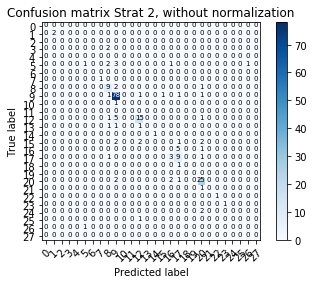

<Figure size 10000x10000 with 0 Axes>

In [71]:
cnf_matrix = confused
np.set_printoptions(precision=2)
import itertools

# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix Strat 2, without normalization')

cm = cnf_matrix
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print(recall)
print(precision)
print(np.mean(recall))
rnum = 0.0
rd = 0
import math
for i in recall:
    if not math.isnan(i) and i > 0:
        rd +=1
        rnum += i
print(rnum/rd)
pn = 0.0
pd = 0
for i in precision:
    if not math.isnan(i) and i > 0:
        pn += i
        pd += 1
print(pn/pd)

print(np.mean(precision))


In [43]:
#try to get the RUC/AUC curve?
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier


#X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
classifier2 = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
y_tr2 = label_binarize(y_tr,classes=classes)
y_te2 = label_binarize(y_te,classes=classes)
y_score2 = classifier2.fit(X_tr, y_tr2).predict(X_te)

n_classes = len(classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_te2[:, i], y_score2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_te2.ravel(), y_score2.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# from collections import Counter
# Counter(y_true) # y_true must be your labels

/opt/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 25 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [39]:
CDL_Dict = {0: "Background", 1: "Corn", 2: "Cotton", 3: "Rice", 4: "Sorghum", 5: "Soybeans", 6: "Sunflower", 10: "Peanuts", 11: "Tobacco", 12: "Sweet Corn", 13: "Pop or Orn Corn", 14: "Mint", 21: "Barley", 22: "Durum Wheat", 23: "Spring Wheat", 24: "Winter Wheat", 25: "Other Small Grains", 26: "Dbl Crop WinWht/Soybeans", 27: "Rye", 28: "Oats", 29: "Millet", 30: "Speltz", 31: "Canola", 32: "Flaxseed", 33: "Safflower", 34: "Rape Seed", 35: "Mustard", 36: "Alfalfa", 37: "Other Hay/Non Alfalfa", 38: "Camelina", 39: "Buckwheat", 41: "Sugarbeets", 42: "Dry Beans", 43: "Potatoes", 44: "Other Crops", 45: "Sugarcane", 46: "Sweet Potatoes", 47: "Misc Vegs & Fruits", 48: "Watermelons", 49: "Onions", 50: "Cucumbers", 51: "Chick Peas", 52: "Lentils", 53: "Peas", 54: "Tomatoes", 55: "Caneberries", 56: "Hops", 57: "Herbs", 58: "Clover/Wildflowers", 59: "Sod/Grass Seed", 60: "Switchgrass", 61: "Fallow/Idle Cropland", 63: "Forest", 64: "Shrubland", 65: "Barren", 66: "Cherries", 67: "Peaches", 68: "Apples", 69: "Grapes", 70: "Christmas Trees", 71: "Other Tree Crops", 72: "Citrus", 74: "Pecans", 75: "Almonds", 76: "Walnuts", 77: "Pears", 81: "Clouds/No Data", 82: "Developed", 83: "Water", 87: "Wetlands", 88: "Nonag/Undefined", 92: "Aquaculture", 111: "Open Water", 112: "Perennial Ice/Snow", 121: "Developed/Open Space", 122: "Developed/Low Intensity", 123: "Developed/Med Intensity", 124: "Developed/High Intensity", 131: "Barren", 141: "Deciduous Forest", 142: "Evergreen Forest", 143: "Mixed Forest", 152: "Shrubland", 176: "Grassland/Pasture", 190: "Woody Wetlands", 195: "Herbaceous Wetlands", 204: "Pistachios", 205: "Triticale", 206: "Carrots", 207: "Asparagus", 208: "Garlic", 209: "Cantaloupes", 210: "Prunes", 211: "Olives", 212: "Oranges", 213: "Honeydew Melons", 214: "Broccoli", 216: "Peppers", 217: "Pomegranates", 218: "Nectarines", 219: "Greens", 220: "Plums", 221: "Strawberries", 222: "Squash", 223: "Apricots", 224: "Vetch", 225: "Dbl Crop WinWht/Corn", 226: "Dbl Crop Oats/Corn", 227: "Lettuce", 229: "Pumpkins", 230: "Dbl Crop Lettuce/Durum Wht", 231: "Dbl Crop Lettuce/Cantaloupe", 232: "Dbl Crop Lettuce/Cotton", 233: "Dbl Crop Lettuce/Barley", 234: "Dbl Crop Durum Wht/Sorghum", 235: "Dbl Crop Barley/Sorghum", 236: "Dbl Crop WinWht/Sorghum", 237: "Dbl Crop Barley/Corn", 238: "Dbl Crop WinWht/Cotton", 239: "Dbl Crop Soybeans/Cotton", 240: "Dbl Crop Soybeans/Oats", 241: "Dbl Crop Corn/Soybeans", 242: "Blueberries", 243: "Cabbage", 244: "Cauliflower", 245: "Celery", 246: "Radishes", 247: "Turnips", 248: "Eggplants", 249: "Gourds", 250: "Cranberries", 254: "Dbl Crop Barley/Soybeans"}

In [41]:
#Find the labels we are using
import numpy as np
toReverse = []
for i in range(28):
    if np.count_nonzero(y_te==i)>2:
        toReverse.append(i)
print(toReverse)

newlabels = le.inverse_transform(toReverse)
print(newlabels)

n_classes = len(set(y))
print(n_classes)

[5, 8, 9, 12, 13, 15, 16, 17, 20]
[ 36.  61.  69.  75.  76. 121. 122. 123. 176.]
28


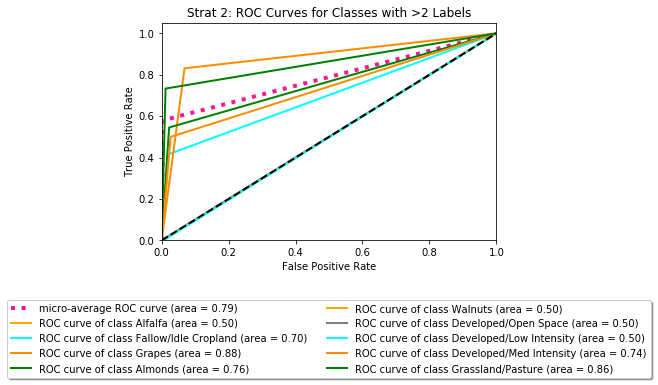

In [45]:
from scipy import interp
from itertools import cycle
import math

lw=2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

l = [36,  61,  69, 75,  76, 121, 122, 123, 176]

# for i in l:
#     print(CDL_Dict[i])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue','darkblue','green','orange','yellow','grey'])
ct = 0
for i, color in zip(range(28), colors):
    if not math.isnan(roc_auc[i]):
        if np.count_nonzero(y_te == i) > 2:
            
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(CDL_Dict[l[ct]], roc_auc[i]))
            ct +=1

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Strat 2: ROC Curves for Classes with >2 Labels')
#plt.legend(loc="lower right")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=2)
plt.show()

# T-SNE

In [46]:
# Setting up model
in_channels = 4
z_dim = 512
cuda = torch.cuda.is_available()
# tilenet = make_tilenet(in_channels=in_channels, z_dim=z_dim)
# Use old model for now
tilenet = ResNet18()
if cuda: tilenet.cuda()

In [47]:
# Load parameters

model_fn = "../models/strat2.1_ep9.ckpt" #open file
tilenet.load_state_dict(torch.load(model_fn), strict=False)
#tilenet.load_state_dict(checkpoint)
tilenet.eval()

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [48]:
tile_dir = '../data/tiles'
n_tiles = 1000
y = np.load(os.path.join(tile_dir, 'y.npy'))
print(y.shape)

(1000,)


In [49]:
t0 = time()
X = np.zeros((n_tiles, z_dim))
beforeEmbed = np.zeros((n_tiles,50,50,4))

for idx in range(n_tiles):
    tile = np.load(os.path.join(tile_dir, '{}tile.npy'.format(idx+1)))
    # Get first 4 NAIP channels (5th is CDL mask)
    tile = tile[:,:,:4]
    tile = tile/255
    beforeEmbed[idx,:,:,:] = tile
    # Rearrange to PyTorch order
    tile = np.moveaxis(tile, -1, 0)
    tile = np.expand_dims(tile, axis=0)
    # Scale to [0, 1]
    #tile = tile / 255
    
    # Embed tile
    tile = torch.from_numpy(tile).float()
    tile = Variable(tile)
    if cuda: tile = tile.cuda()
    z = tilenet.encode(tile)
    if cuda: z = z.cpu()
    z = z.data.numpy() #1 by 512
    X[idx,:] = z
t1 = time()

print(X.shape)
print(beforeEmbed.shape)
print('Embedded {} tiles: {:0.3f}s'.format(n_tiles, t1-t0))

(1000, 512)
(1000, 50, 50, 4)
Embedded 1000 tiles: 14.369s


In [50]:
Z = X
patches = beforeEmbed
#print(y)

In [56]:
mapping = {0: "Background", 1: "Corn", 2: "Cotton", 3: "Rice", 4: "Sorghum", 5: "Soybeans", 6: "Sunflower", 10: "Peanuts", 11: "Tobacco", 12: "Sweet Corn", 13: "Pop or Orn Corn", 14: "Mint", 21: "Barley", 22: "Durum Wheat", 23: "Spring Wheat", 24: "Winter Wheat", 25: "Other Small Grains", 26: "Dbl Crop WinWht/Soybeans", 27: "Rye", 28: "Oats", 29: "Millet", 30: "Speltz", 31: "Canola", 32: "Flaxseed", 33: "Safflower", 34: "Rape Seed", 35: "Mustard", 36: "Alfalfa", 37: "Other Hay/Non Alfalfa", 38: "Camelina", 39: "Buckwheat", 41: "Sugarbeets", 42: "Dry Beans", 43: "Potatoes", 44: "Other Crops", 45: "Sugarcane", 46: "Sweet Potatoes", 47: "Misc Vegs & Fruits", 48: "Watermelons", 49: "Onions", 50: "Cucumbers", 51: "Chick Peas", 52: "Lentils", 53: "Peas", 54: "Tomatoes", 55: "Caneberries", 56: "Hops", 57: "Herbs", 58: "Clover/Wildflowers", 59: "Sod/Grass Seed", 60: "Switchgrass", 61: "Fallow/Idle Cropland", 63: "Forest", 64: "Shrubland", 65: "Barren", 66: "Cherries", 67: "Peaches", 68: "Apples", 69: "Grapes", 70: "Christmas Trees", 71: "Other Tree Crops", 72: "Citrus", 74: "Pecans", 75: "Almonds", 76: "Walnuts", 77: "Pears", 81: "Clouds/No Data", 82: "Developed", 83: "Water", 87: "Wetlands", 88: "Nonag/Undefined", 92: "Aquaculture", 111: "Open Water", 112: "Perennial Ice/Snow", 121: "Developed/Open Space", 122: "Developed/Low Intensity", 123: "Developed/Med Intensity", 124: "Developed/High Intensity", 131: "Barren", 141: "Deciduous Forest", 142: "Evergreen Forest", 143: "Mixed Forest", 152: "Shrubland", 176: "Grassland/Pasture", 190: "Woody Wetlands", 195: "Herbaceous Wetlands", 204: "Pistachios", 205: "Triticale", 206: "Carrots", 207: "Asparagus", 208: "Garlic", 209: "Cantaloupes", 210: "Prunes", 211: "Olives", 212: "Oranges", 213: "Honeydew Melons", 214: "Broccoli", 216: "Peppers", 217: "Pomegranates", 218: "Nectarines", 219: "Greens", 220: "Plums", 221: "Strawberries", 222: "Squash", 223: "Apricots", 224: "Vetch", 225: "Dbl Crop WinWht/Corn", 226: "Dbl Crop Oats/Corn", 227: "Lettuce", 229: "Pumpkins", 230: "Dbl Crop Lettuce/Durum Wht", 231: "Dbl Crop Lettuce/Cantaloupe", 232: "Dbl Crop Lettuce/Cotton", 233: "Dbl Crop Lettuce/Barley", 234: "Dbl Crop Durum Wht/Sorghum", 235: "Dbl Crop Barley/Sorghum", 236: "Dbl Crop WinWht/Sorghum", 237: "Dbl Crop Barley/Corn", 238: "Dbl Crop WinWht/Cotton", 239: "Dbl Crop Soybeans/Cotton", 240: "Dbl Crop Soybeans/Oats", 241: "Dbl Crop Corn/Soybeans", 242: "Blueberries", 243: "Cabbage", 244: "Cauliflower", 245: "Celery", 246: "Radishes", 247: "Turnips", 248: "Eggplants", 249: "Gourds", 250: "Cranberries", 254: "Dbl Crop Barley/Soybeans"}
#print(mapping.values())
dict2 = {}
for i in range(28):
    revd = le.inverse_transform([i])
    revd = int(revd)
    dict2[i] = CDL_Dict[revd]
print(dict2)

{0: 'Corn', 1: 'Cotton', 2: 'Barley', 3: 'Winter Wheat', 4: 'Oats', 5: 'Alfalfa', 6: 'Onions', 7: 'Tomatoes', 8: 'Fallow/Idle Cropland', 9: 'Grapes', 10: 'Other Tree Crops', 11: 'Citrus', 12: 'Almonds', 13: 'Walnuts', 14: 'Open Water', 15: 'Developed/Open Space', 16: 'Developed/Low Intensity', 17: 'Developed/Med Intensity', 18: 'Developed/High Intensity', 19: 'Shrubland', 20: 'Grassland/Pasture', 21: 'Pistachios', 22: 'Triticale', 23: 'Garlic', 24: 'Oranges', 25: 'Pomegranates', 26: 'Dbl Crop WinWht/Corn', 27: 'Dbl Crop WinWht/Sorghum'}


In [67]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import offsetbox
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import Counter

# Figure A6

# Z is an array of all the embeddings, dimension (n, 512)
# y is an array of all the labels, dimension (n,)
# patches is an array of all the tiles, dimension (n, 50, 50, 4)
# we filtered Z and y to contain only the top 10 CDL classes for this visualization

# PCA on embeddings (pre-TSNE processing)
n_pca = 20
t0 = time()
Z_pca = PCA(n_pca).fit_transform(Z)
print('PCA: {}, {:0.3f}s'.format(Z_pca.shape, time()-t0))

def produce_tsne_plot(n_trials, init='pca', label_size=25):
    for _ in range(n_trials):
        # Randomly sample subset
        n_sample = 1000
        idxs = np.random.choice(range(len(y)), size=n_sample, replace=False)
        Z_sample = Z_pca[idxs]
        y_sample = y[idxs]
        
        p_sample = [patches[idx] for idx in idxs]

        # TSNE on random sample of PCA of embeddings
        n_tsne = 2
        Z_tsne = TSNE(n_tsne, init=init).fit_transform(Z_sample)

        # Plot TSNE embeddings with color
        scale = 12
        figsize = (2.25*scale, 1*scale)
        axis_offset = 0.025
        # Patch embedding parameters
        fs_labels = 14
        min_dist = 3e-3
        cbar_labels = [class_name for idx, class_name in mapping.items()]
        cbar_labels = ["Grapes","Almonds","Grassland/Pasture","Fallow/Idle Cropland", "Developed/Med Intensity", "Alfalfa",
                      "Developed/Open Space", "Developed/Low Intensity", "Pistachios", "Tomatoes"] 
        top_k = 10
        # CDL label parameters
        cm = ListedColormap(sns.color_palette('hls', top_k))
        marker_size = 100

        # Plot patch embeddings
        fig, (ax1, ax2, cax) = plt.subplots(ncols=3, figsize=figsize,
            gridspec_kw={"width_ratios":[1, 1, 0.05]})
        x_min, x_max = np.min(Z_tsne, 0), np.max(Z_tsne, 0)
        X = (Z_tsne - x_min) / (x_max - x_min)
        shown_patches = np.array([[1, 1]])
        for i in range(X.shape[0]):
            # Don't plot images too close in embedding space
            dist = np.sum((X[i] - shown_patches) ** 2, 1)
            if np.min(dist) < min_dist: continue
            # Add patch to display
            img = p_sample[i][:,:,:3]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img),
                X[i], frameon=False)
            ax1.add_artist(imagebox)
        ax1.set_xlim([-axis_offset, 1+axis_offset])
        ax1.set_ylim([-axis_offset, 1+axis_offset])
        ax1.axis('off')

        # Plot CDL labels
        x_min, x_max = np.min(Z_tsne, 0), np.max(Z_tsne, 0)
        X = (Z_tsne - x_min) / (x_max - x_min)
        im = ax2.scatter(X[:,0], X[:,1], c=y_sample, cmap=cm, s=marker_size)
        ax2.set_xlim([-axis_offset, 1+axis_offset])
        ax2.set_ylim([-axis_offset, 1+axis_offset])
        ax2.axis('off')
        # Colorbar stuff
        cbar = fig.colorbar(im, cax=cax, spacing='proportional')
        print(cbar_labels)
        cbar.set_ticks([12+23*idx for idx in range(10)])
        cbar.ax.set_yticklabels(cbar_labels, size=label_size)
        cbar.ax.invert_yaxis()
        
        

        plt.show()

PCA: (1000, 20), 0.035s


['Grapes', 'Almonds', 'Grassland/Pasture', 'Fallow/Idle Cropland', 'Developed/Med Intensity', 'Alfalfa', 'Developed/Open Space', 'Developed/Low Intensity', 'Pistachios', 'Tomatoes']


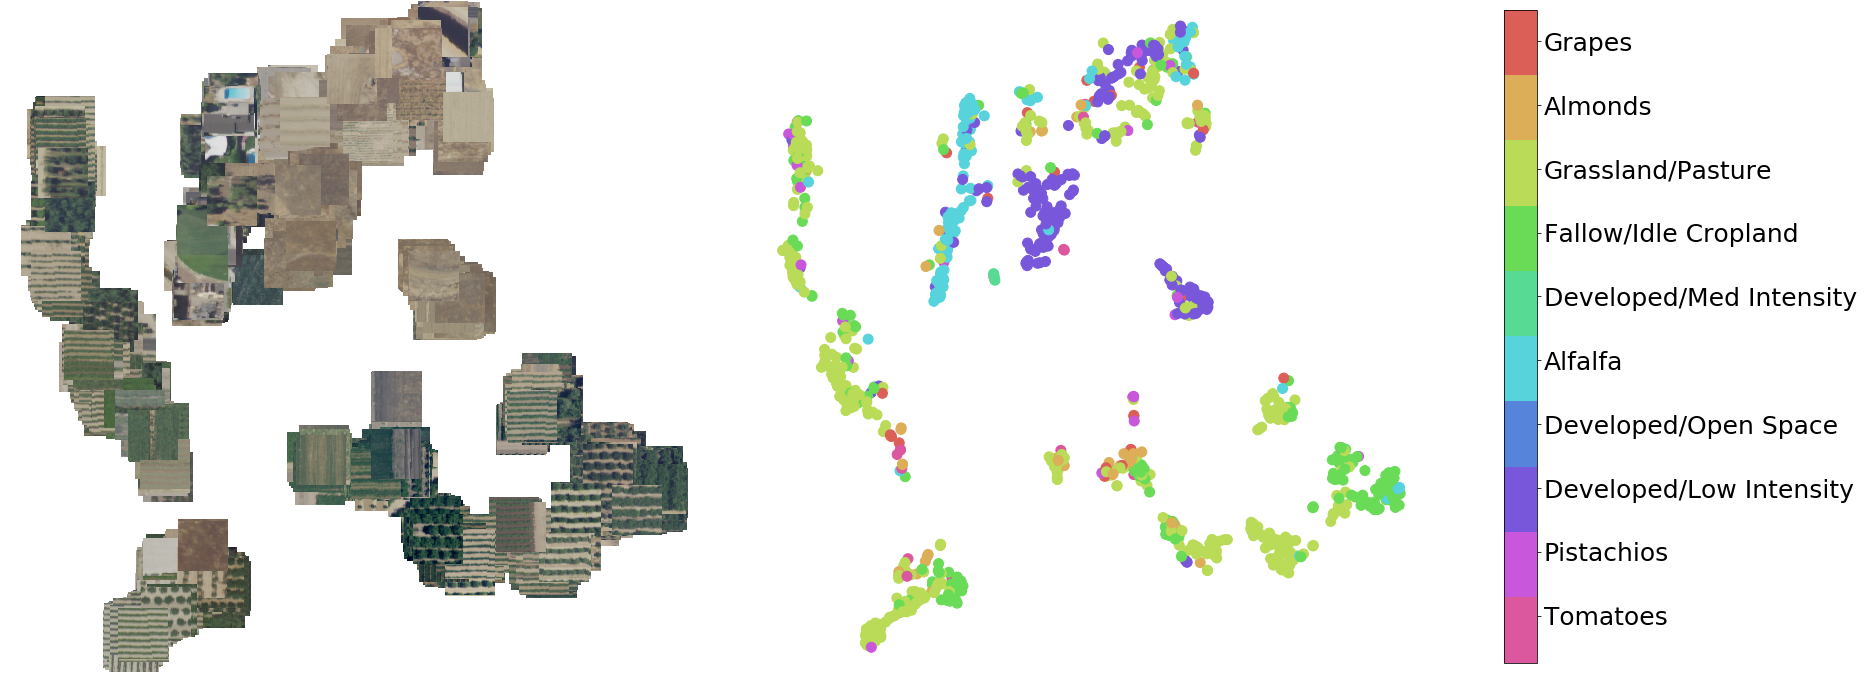

In [68]:
produce_tsne_plot(1)